In [60]:
import pandas as pd
import numpy as np
import os
pd.set_option('display.max_columns', 500)
import itertools
from pprint import pprint
#сунул функции в библиотеку
import trend_helpers
import matplotlib.pyplot as plt

# 1. Load and preprocess trend data

In [7]:
IDcount = 0

file = 'marked_check_normal_trends_crossed2.csv'
df = pd.read_csv(file, header=None)
df = df.rename(index=str, columns={0: 'trend_type', 
                                   1: 'trend_params', 
                                   2: 'ratings'})
df['ID']=df.index
df['ID']=df['ID'].apply(lambda x: int(x) + 100000)
print(len(df))
df.head()

116


,trend_type,trend_params,ratings,ID
0,1,"[[156049, 164867, 17.279498240432385, array([-...","[3, 2, 63041, 63180, 63041, 63180, 62935, 63180]",100000
1,2,"[[175005, 184926, 25.315626489229555, array([5...","[3, 3, 63159, 62970, 63159, 62970, 63255, 62970]",100001
2,1,"[[184229, 189013, 23.58949057754647, array([-3...","[4, 3, 62966, 63120, 62966, 63120, 62966, 63120]",100002
3,1,"[[202796, 205102, 31.395030163719422, array([-...","[2, 2]",100003
4,1,"[[202796, 205344, 41.68901015180105, array([-3...","[4, 3, 62769, 62819, 62769, 62819, 62755, 62819]",100004


In [8]:
#extract 2 first values of 'ratings'
df['ratings'] = df['ratings'].apply(lambda x: eval(x)[0:2])
df.head()
#TODO: make cell idempotent

,trend_type,trend_params,ratings,ID
0,1,"[[156049, 164867, 17.279498240432385, array([-...","[3, 2]",100000
1,2,"[[175005, 184926, 25.315626489229555, array([5...","[3, 3]",100001
2,1,"[[184229, 189013, 23.58949057754647, array([-3...","[4, 3]",100002
3,1,"[[202796, 205102, 31.395030163719422, array([-...","[2, 2]",100003
4,1,"[[202796, 205344, 41.68901015180105, array([-3...","[4, 3]",100004


In [12]:
df_parsed = trend_helpers.pretify_dataframe(df)
df_parsed.head(3)

,trend_type,ratings,ID,trend_start,trend_end,importance,k,b,dispersion,absolute_trend_lenght,r_squared_of_trend,tops_coordinates,tops_height,tops_width,tops_HW_ratio,tops_count,peaks_coordinates,peaks_height,peaks_width,peaks_HW_ratio,peaks_count
0,1,"[3, 2]",100000,156049,164867,17.279498,-0.000023,66.794773,2551.000,8816.000002,2.510438e-06,"[(155012, 63.185), (156674, 63.185), (157228, ...","[0.06461462081585267, 0.06461462081585267, 0.0...","[1037, 1037, 245, 7306, 228, 228]","[6.230918111461203e-05, 6.230918111461203e-05,...",6,"[(156049, 63.26375), (157086, 63.24125), (1573...","[0.07874999999999943, 0.04509476534295942, 0.0...","[1662, 554, 5734, 1808, 323]","[4.7382671480144065e-05, 8.139849339884372e-05...",5
1,2,"[3, 3]",100001,175005,184926,25.315626,0.000006,62.041194,2350.880,9919.000000,8.054267e-07,"[(173242, 63.165), (175776, 63.165), (182451, ...","[0.09562696696405482, 0.09562696696405482, 0.1...","[1763, 1763, 7861, 77, 35, 183, 183]","[5.424104762566921e-05, 5.424104762566921e-05,...",7,"[(175005, 63.065), (176768, 63.075), (184629, ...","[0.10000000000000142, 0.10337528089887371, 0.0...","[2534, 6675, 2210, 68, 86, 292]","[3.946329913180798e-05, 1.548693346799606e-05,...",6
2,1,"[4, 3]",100002,184229,189013,23.589491,-0.000034,69.460283,1013.375,4781.000003,1.005475e-06,"[(183643, 63.12125), (184629, 63.12125), (1868...","[0.044558243070433434, 0.044558243070433434, 0...","[586, 586, 3222, 245, 728, 728]","[7.603795745807753e-05, 7.603795745807753e-05,...",6,"[(184229, 63.18), (184815, 63.15875), (188037,...","[0.058749999999996305, 0.050081618962423136, 0...","[986, 2236, 1221, 798, 854]","[5.958417849898205e-05, 2.239786178999246e-05,...",5


# 1.2 шкалирование
Нейронка должна кушать циферки одного порядка,иначе будет очень долго и тяжело их переваривать

шкалирование оси y будет менятся от инструмента к инструменту. За шкалирование Y отвечает ticker_scale

In [81]:
df_scaled = df_parsed.copy()

In [103]:
type(df_parsed['tops_height'][1][1])

float

In [109]:
def coords_scaler(coords_pair, trend_start, ticker_scale):
    """
    Вычетает из координат Х начало тренда;
    Координату тренда делит на коэфициент шкалирования цены инструмента
    
    :ticker_scale: коэфициент шкалирования цены инструмента
    :coords_pair: пара coords_list
    :trend_start: начало тренда
    :returns: шкалированный список пар
    """
    
    x = coords_pair[0] - trend_start
    y = coords_pair[1]/ticker_scale
    return [x,y]

ticker_scale = 10

df_scaled['importance'] = df_parsed['importance']/10
df_scaled['k'] = df_parsed['k']*10000
df_scaled['b'] = df_parsed['b']/10
df_scaled['dispersion'] = df_parsed['dispersion']/1000
df_scaled['absolute_trend_lenght'] = df_parsed['absolute_trend_lenght']/1000
df_scaled['r_squared_of_trend'] = df_parsed['r_squared_of_trend']*1000000
df_scaled['tops_height'] = df_parsed['tops_height']*100
df_scaled['tops_width'] = df_parsed['tops_width'].apply(map(lambda x: float(x)/100))
df_scaled['tops_HW_ratio'] = df_parsed['tops_HW_ratio']*10000
df_scaled['peaks_height'] = list(map(lambda x: x*100, df_parsed['peaks_height']))
df_scaled['peaks_width'] =  (map(lambda x: x/100, df_parsed['peaks_width']))
df_scaled['peaks_HW_ratio'] = df_parsed['peaks_HW_ratio']*10000
# координаты пиков-вершин нормируем вычетая точку начала тренда для X и деля на коэфициент масштаба инструмента по Y
#df_scaled['tops_coordinates'] = list(map(coords_scaler(df_parsed['tops_coordinates'], 
#                                                       df_parsed['trend_start'], 
#                                                       ticker_scale)))

TypeError: map() must have at least two arguments.

In [89]:
df_scaled.head()

,trend_type,ratings,ID,trend_start,trend_end,importance,k,b,dispersion,absolute_trend_lenght,r_squared_of_trend,tops_coordinates,tops_height,tops_width,tops_HW_ratio,tops_count,peaks_coordinates,peaks_height,peaks_width,peaks_HW_ratio,peaks_count
0,1,"[3, 2]",100000,156049,164867,1.727950,-0.226276,6.679477,2.551000,8.816,2.510438,<map object at 0x00000195AFB29518>,"[0.06461462081585267, 0.06461462081585267, 0.0...",<map object at 0x00000195AFA7CAC8>,"[6.230918111461203e-05, 6.230918111461203e-05,...",6,"[(156049, 63.26375), (157086, 63.24125), (1573...",<map object at 0x00000195AFA5F6A0>,<map object at 0x00000195AFA7C2B0>,"[4.7382671480144065e-05, 8.139849339884372e-05...",5
1,2,"[3, 3]",100001,175005,184926,2.531563,0.058494,6.204119,2.350880,9.919,0.805427,<map object at 0x00000195AFB29518>,"[0.09562696696405482, 0.09562696696405482, 0.1...",<map object at 0x00000195AFA7CAC8>,"[5.424104762566921e-05, 5.424104762566921e-05,...",7,"[(175005, 63.065), (176768, 63.075), (184629, ...",<map object at 0x00000195AFA5F6A0>,<map object at 0x00000195AFA7C2B0>,"[3.946329913180798e-05, 1.548693346799606e-05,...",6
2,1,"[4, 3]",100002,184229,189013,2.358949,-0.340926,6.946028,1.013375,4.781,1.005475,<map object at 0x00000195AFB29518>,"[0.044558243070433434, 0.044558243070433434, 0...",<map object at 0x00000195AFA7CAC8>,"[7.603795745807753e-05, 7.603795745807753e-05,...",6,"[(184229, 63.18), (184815, 63.15875), (188037,...",<map object at 0x00000195AFA5F6A0>,<map object at 0x00000195AFA7C2B0>,"[5.958417849898205e-05, 2.239786178999246e-05,...",5
3,1,"[2, 2]",100003,202796,205102,3.139503,-0.316307,6.927989,0.437840,2.291,1.454511,<map object at 0x00000195AFB29518>,"[0.040379751582626966, 0.040379751582626966, 0...",<map object at 0x00000195AFA7CAC8>,"[6.279899157484753e-05, 6.279899157484753e-05,...",7,"[(202796, 62.865), (203439, 62.845), (203547, ...",<map object at 0x00000195AFA5F6A0>,<map object at 0x00000195AFA7C2B0>,"[5.06756756756776e-05, 4.912381499569153e-05, ...",6
4,1,"[4, 3]",100004,202796,205344,4.168901,-0.302680,6.900311,0.427667,2.547,1.729611,<map object at 0x00000195AFB29518>,"[0.04049133576674535, 0.04049133576674535, 0.0...",<map object at 0x00000195AFA7CAC8>,"[6.297252840862418e-05, 6.297252840862418e-05,...",8,"[(202796, 62.865), (203439, 62.845), (203547, ...",<map object at 0x00000195AFA5F6A0>,<map object at 0x00000195AFA7C2B0>,"[5.06756756756776e-05, 4.912381499569153e-05, ...",7


#### картинки до шкалирования

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2862: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


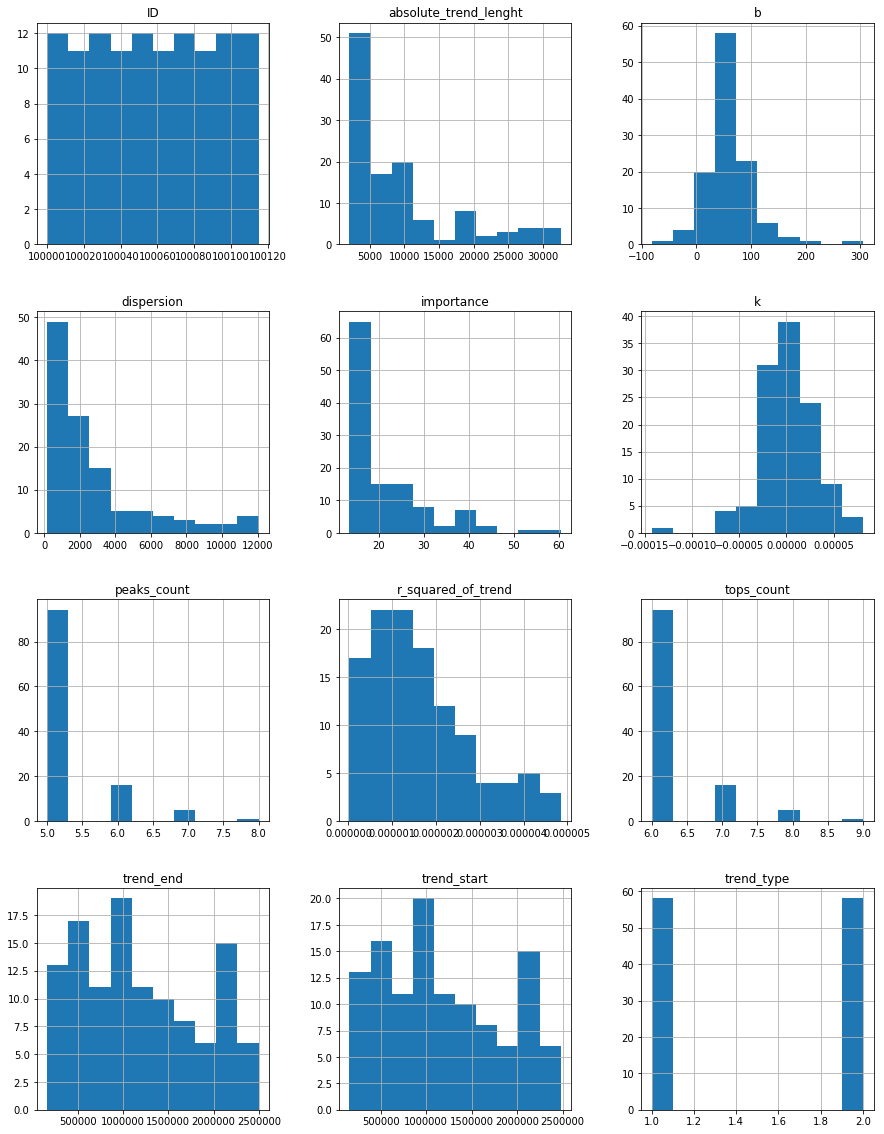

In [83]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
df_parsed.hist(ax = ax)
plt.show()

#### распределения после шкалирования

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2862: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


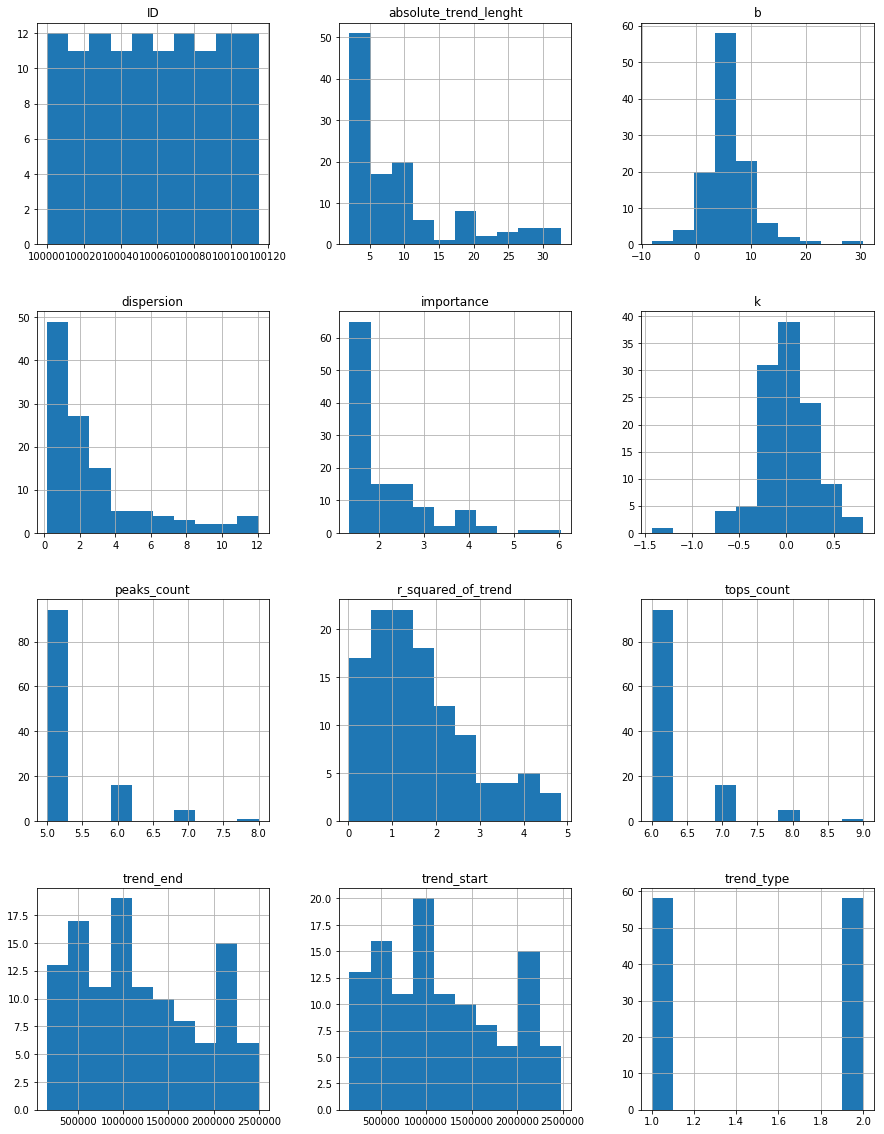

In [87]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
df_scaled.hist(ax = ax)
plt.show()

In [74]:
trend_vector = []
row = df_parsed.iloc[1]
trend_vector.append(row['importance'])
trend_vector.append(row['k']*10000)
trend_vector.appemd(row['b'])/10
trend_vector.appemd(row['tops_count'])

    trend_vector.append(k)
if len(k) > 5:
        

2
175005
184926
25.315626489229555
5.84937292e-06
62.0411937
2350.88
9919.000000166663
8.05426697e-07
[(173242, 63.165), (175776, 63.165), (182451, 63.255), (184661, 63.135), (184729, 63.13125), (184815, 63.15875), (185107, 63.15875)]
[0.09562696696405482, 0.09562696696405482, 0.14658240271702283, 0.013655288561814416, 0.009507531203198027, 0.03650448513199933, 0.03650448513199933]
[1763, 1763, 7861, 77, 35, 183, 183]
[5.424104762566921e-05, 5.424104762566921e-05, 1.864678828609882e-05, 0.00017734140989369372, 0.00027164374866280077, 0.00019947806083059743, 0.00019947806083059743]
7
[(175005, 63.065), (176768, 63.075), (184629, 63.12125), (184706, 63.12125), (184741, 63.1225), (184924, 63.1225)]
[0.10000000000000142, 0.10337528089887371, 0.015487556561076588, 0.011268382352938033, 0.012587209302324709, 0.03624999999999545]
[2534, 6675, 2210, 68, 86, 292]
[3.946329913180798e-05, 1.548693346799606e-05, 7.007944145283524e-06, 0.0001657115051902652, 0.0001463628988642408, 0.000124143835616

In [10]:
df_trend_splited = trend_helpers.extremum_spliter(df_parsed)
df_trend_splited.head()

,trend_start,trend_end,importance,k,b,dispersion,absolute_trend_lenght,r_squared_of_trend,tops_count,peaks_count,ID,coordinates_X,coordinates_Y,height,width,HW_ratio,extremum_type,ratings
0,156049,164867,17.279498,-0.000023,66.794773,2551.0,8816.000002,0.000003,6,5,100000,155012,63.18500,0.064615,1037,0.000062,1,"[3, 2]"
1,156049,164867,17.279498,-0.000023,66.794773,2551.0,8816.000002,0.000003,6,5,100000,156674,63.18500,0.064615,1037,0.000062,1,"[3, 2]"
2,156049,164867,17.279498,-0.000023,66.794773,2551.0,8816.000002,0.000003,6,5,100000,157228,63.20000,0.037079,245,0.000151,1,"[3, 2]"
3,156049,164867,17.279498,-0.000023,66.794773,2551.0,8816.000002,0.000003,6,5,100000,162962,62.93500,0.172332,7306,0.000024,1,"[3, 2]"
4,156049,164867,17.279498,-0.000023,66.794773,2551.0,8816.000002,0.000003,6,5,100000,164770,63.04125,0.025171,228,0.000110,1,"[3, 2]"


# 2. I AM GOD ML

In [2]:
import csv
import tensorflow as tf 
import numpy as np
import pandas

In [3]:
################################################################################
#trendspath ="marked_check_normal_trends_crossed2.csv" # тута ненормированные
#colnames = ['<price_eba>']
#m = 1000 # от 1000 до 4000 линейная зависимость
#counter_list = []
#def correction(x, xx, xn):
#    """
#    данная функция переводит ординаты тиковых точек 
#    графика в ординаты в диапазоне (0, n)'
#    """
#    x_corrected = (x-xn)/(xx-xn)
#    return(x_corrected)
#
#
#with open (trendspath , "r") as csvfile:
#    reader = csv.reader(csvfile, delimiter =  ",")
#    my_list0 = list(reader)
#    my_list_chisto_chisto = []
#    for i in my_list0:
#        if len(i) == 3: 
#            # в некоторых примерах почему-то по 2 пары оценок. нафиг их
#            direction_of_deal = int(i[0])
#            basic_parameters = i[1].split('[[')[1].split(',')
#            list_of_marks = i[2].split(',')[0][1:]
#            my_exp_mark = int(i[2].split(',')[0][1:]) 
#            tech_mark = int(i[2].split(',')[1][:-1])
#            first_dot = int(basic_parameters[0])
#            last_dot = int(basic_parameters[1])
#            if last_dot > 0:
#                angle = float(basic_parameters[3].split('([')[1])
#                b_coeff = float(basic_parameters[4].split('])')[0])
#                counter_list.append([direction_of_deal, first_dot, last_dot, angle, b_coeff, my_exp_mark])
#my_list = sorted(counter_list, key = lambda  x: x[1]) # сортируем       
#max_counter = len(my_list) - 5

ValueError: invalid literal for int() with base 10: ' '

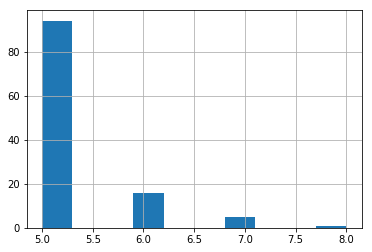

In [67]:
df_parsed['peaks_count'].hist()
plt.show()

In [25]:
df_parsed.iloc[0]['tops_coordinates'][0][0]

155012

In [52]:
m = 1000
#ГРУЗИМ ТИКИ
# тута тики
datapath='USDRUB_TOM_2018_07_10pure.csv'
#header = 1!!!!
data = pandas.read_csv(datapath, names=colnames, sep = '\t', header = 1)
cols = data.columns
y_column = data[cols[0]]
y_list = list(y_column)
x_list = list(range(len(y_list)))

k = 0
X_data = [] # картинки
Y_data = [] # оценки картинок
for k in range(len(df_parsed)-1):
    line_y = []
    line_y_trend = []
    direction = df_parsed.iloc[k]['trend_type']
    rating = df_parsed.iloc[k]['ratings'][0] 
    
    first_dot =  df_parsed.iloc[k]['trend_start']
    last_dot = df_parsed.iloc[k]['trend_end']    
    first_extremum = min(df_parsed.iloc[k]['tops_coordinates'][0][0], 
                         df_parsed.iloc[k]['peaks_coordinates'][0][0])
    adjusted_first_dot = first_dot - (first_extremum - first_dot)

    angle = df_parsed.iloc[k,6]
    b_coeff =  df_parsed.iloc[k,7]
    
    #список ординат картинки без вычета тренда
    xplot = x_list[adjusted_first_dot:last_dot] 
    yplot = y_list[adjusted_first_dot:last_dot] 
    
    #список ординат картинки с учетом вычетенного тренда
    yplot_trend = []
    print('new row!')
    print(len(xplot))
    print(adjusted_first_dot)
    print(last_dot)
    # линия поддержки. график - тренд
    if direction == 2:
        for ii, jj in zip(xplot, yplot):
            corr_val = jj - angle*ii - b_coeff
            yplot_trend.append(corr_val)
            
    # линия сопротивления. тренд - график
    if direction == 1:
        for ii,jj in zip(xplot, yplot):
            corr_val = angle*ii + b_coeff - jj
            yplot_trend.append(corr_val)
    y_max = max(yplot_trend)  
    y_min = min(yplot_trend)
    
    if len(xplot) > 1000:
        # ширина свечи
        step = int((len(xplot))/m)
        step_list = list(range(m))
        for i,j in zip(step_list[:-1], step_list[1:]):
            candle_start = i*step
            candle_end = j*step
            candlex = xplot[candle_start:candle_end]
            candley = yplot_trend[candle_start:candle_end]
            candle_max = max(candley)
            candle_min = min(candley)
            candle_mean = np.mean(candley)
            candle_max_corrected = correction(candle_max, y_max, y_min)
            candle_min_corrected = correction(candle_min, y_max, y_min)
            candle_mean_corrected = correction(candle_mean, y_max, y_min) 
            candle_list = [candle_max_corrected, candle_min_corrected, candle_mean_corrected]
            line_y.append(candle_list)
        k += 1
        X_data.append(line_y)
        Y_data.append(rating)
X_data = np.array(X_data)
Y_data = np.array(Y_data)
###############################################################################
x_train = X_data[:100]
y_train = Y_data[:100]
x_test = X_data[100:]
y_test = Y_data[100:]

new row!
7781
157086
164867
new row!
8158
176768
184926
new row!
4198
184815
189013
new row!
1663
203439
205102
new row!
1905
203439
205344
new row!
3803
202439
206242
new row!
10630
198737
209367
new row!
2892
275699
278591
new row!
684
293346
294030
new row!
299
318242
318541
new row!
5940
322046
327986
new row!
11654
322046
333700
new row!
2742
375389
378131
new row!
281
401004
401285
new row!
7421
401342
408763
new row!
1846
409109
410955
new row!
2978
409109
412087
new row!
2988
409109
412097
new row!
8343
411787
420130
new row!
608
471758
472366
new row!
8481
500299
508780
new row!
677
548543
549220
new row!
5723
550124
555847
new row!
6055
549958
556013
new row!
1136
567812
568948
new row!
1760
574551
576311
new row!
1484
591337
592821
new row!
549
617382
617931
new row!
9027
617060
626087
new row!
1243
627401
628644
new row!
1579
670205
671784
new row!
841
694729
695570
new row!
3351
695199
698550
new row!
22348
739098
761446
new row!
27117
739098
766215
new row!
1297
773109
77

In [54]:
len(X_data)

96

# 3. deep learning time!

In [ ]:

#mnist = tf.keras.datasets.mnist  # mnist is a dataset of 28x28 images of handwritten digits and their labels
#(x_train, y_train),(x_test, y_test) = mnist.load_data()  # unpacks images to x_train/x_test and labels to y_train/y_test

#x_train = tf.keras.utils.normalize(x_train, axis=1)  # scales data between 0 and 1
#x_test = tf.keras.utils.normalize(x_test, axis=1)  # scales data between 0 and 1

model = tf.keras.models.Sequential()  # a basic feed-forward model
model.add(tf.keras.layers.Flatten())  # takes our 28x28 and makes it 1x784
model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu))  # a simple fully-connected layer, 128 units, relu activation
model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu))  # a simple fully-connected layer, 128 units, relu activation
model.add(tf.keras.layers.Dense(4, activation=tf.nn.softmax))  # our output layer. 10 units for 10 classes. Softmax for probability distribution

model.compile(optimizer='adam',  # Good default optimizer to start with
              loss='sparse_categorical_crossentropy',  # how will we calculate our "error." Neural network aims to minimize loss.
              metrics=['accuracy'])  # what to track

model.fit(x_train, y_train, epochs=30)  # train the model

val_loss, val_acc = model.evaluate(x_test, y_test)  # evaluate the out of sample data with model
print(val_loss)  # model's loss (error)
print(val_acc)  # model's accuracy
model.save('epic_num_reader.model')
new_model = tf.keras.models.load_model('epic_num_reader.model')
prediction = new_model.predict([x_test])# дает распределение вероятностей
print(np.argmax(prediction(0)))



#import matplotlib.pyplot as plt
#plt.imshow(x_test[0], cmap = plt.cm.binary)
#plt.show
